#          Random Forest Model on Bank Marketing Data Set
Author: Javed Shaik

The Dataset examined for this study is a Bank Marketing Data Set which can be downloaded at 

<https://archive.ics.uci.edu/ml/datasets/Bank+Marketing>

## Information:
This dataset comes from marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls.


This Model looks at the attributes listed below to predict whether a bank client will suscribe to a term deposit

A term deposit is a cash investment held at a bank institution. The cash can only be withdrawn at the end of the period agreed upon or with a penalty fee of withdrawing early.

## Input variables:

### Bank client data:
- age (numeric)
- job : type of job  (categorical:"admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue collar","self-employed","retired","technician","services")                                  
- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)<br>
- education (categorical: "unknown","secondary","primary","tertiary")<br>
- default: has credit in default? (binary: "yes","no")<br>
- balance: average yearly balance, in euros (numeric) <br>
- housing: has housing loan? (binary: "yes","no")<br>
- loan: has personal loan? (binary: "yes","no")<br>
### Related with the last contact of the current campaign:
- contact: contact communication type (categorical: "unknown","telephone","cellular") <br>
- day: last contact day of the month (numeric)<br>
- month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")<br>
- duration: last contact duration, in seconds (numeric)<br>
### Other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)<br>
- previous: number of contacts performed before this campaign and for this client (numeric)<br>
- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")<br>

## Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: "yes","no")<br>




In [1]:
#Formatting cells to Black
%load_ext blackcellmagic

In [328]:
# Import relevant Python packages
import numpy as np
import pandas as pd
import graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score , confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [329]:
#Read in csv file which is seperated with ";" from the website listed above
df = pd.read_csv("bank/bank-full.csv", sep =';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [330]:
df.shape

(45211, 17)

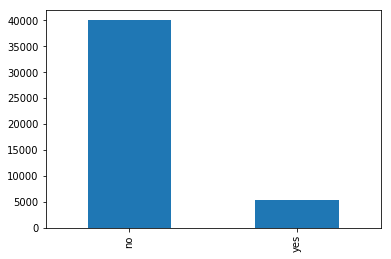

In [331]:
#General look at outcomes
pd.value_counts(df['y']).plot.bar();

In [332]:
#Check if there are any null values in the dataset
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# Data Wrangling
- Cleaning up and preparing the data for analysis 

In [333]:
#Going to Clean Dataset by only looking at known values
df= df[df["contact"]!="unknown"]
df = df[df["poutcome"]!="unknown"]
df = df[df["job"]!="unknown"]

In [334]:
df.shape

(8149, 17)

You can see that the data had been significantly decreased by doing this. Dropping around 30000 entries

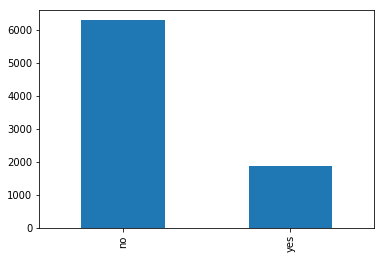

In [335]:
#General look at the outcome counts of the dataset.
pd.value_counts(df['y']).plot.bar();

In [336]:
#Creating a copy so that we can avoid error messages as well as not taint the 
#orignial data
df2 = df.copy()
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
24060,33,admin.,married,tertiary,no,882,no,no,telephone,21,oct,39,1,151,3,failure,no
24062,42,admin.,single,secondary,no,-247,yes,yes,telephone,21,oct,519,1,166,1,other,yes
24064,33,services,married,secondary,no,3444,yes,no,telephone,21,oct,144,1,91,4,failure,yes
24072,36,management,married,tertiary,no,2415,yes,no,telephone,22,oct,73,1,86,4,other,no
24077,36,management,married,tertiary,no,0,yes,no,telephone,23,oct,140,1,143,3,failure,yes


# Encoding Data
- We are going to modify the dataset so that we can turn all the categorical and binary values into numbers.
- We also going to turn the continous variables into discrete by looking at the ranges and dividing it up into bins

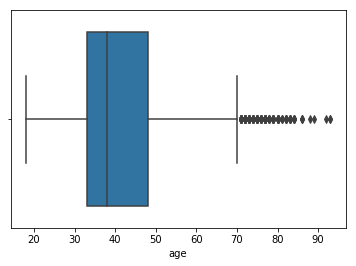

In [243]:
#First feature we are looking at is Age
#Age is continuous and to help organized the data we can have it become categorical 
#by taking a look at the ranges
#The boxplot will help divide the ages into subgroups
sns.boxplot(x ="age", data = df2);

In [244]:
#Gets quantile values
df2["age"].quantile([0.25,0.50,0.75,1])

0.25    33.0
0.50    38.0
0.75    48.0
1.00    93.0
Name: age, dtype: float64

In [245]:
#Looking at the boxplot we can divide age into 4 categories and the values can 
#be seen below
df2.loc[df2.age<33,"age"] = 1
df2.loc[(df2.age>=33) & (df.age<48),"age"] = 2
df2.loc[(df2.age>=48) & (df.age<70),"age"] = 3
df2.loc[(df2.age>=70),"age"] = 4

In [300]:
# Tranforming the categorical variables into numbers can be done by LablelEncoder 
#a function from Scikit Learn
df2['job']= LabelEncoder().fit_transform(df2['job']) 
df2['marital']= LabelEncoder().fit_transform(df2['marital']) 
df2['education']= LabelEncoder().fit_transform(df2['education']) 
df2['default']= LabelEncoder().fit_transform(df2['default']) 
df2['housing']= LabelEncoder().fit_transform(df2['housing']) 
df2['loan']= LabelEncoder().fit_transform(df2['loan']) 
df2['contact']= LabelEncoder().fit_transform(df2['contact'])
df2["month"]= LabelEncoder().fit_transform(df2['month'])
df2["poutcome"]= LabelEncoder().fit_transform(df2['poutcome'])

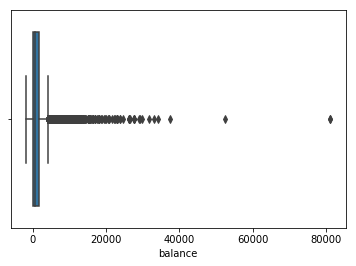

In [337]:
#Balance is continuous and to help organized the data we can have it become categorical
#by taking a look at the ranges
#The boxplot will help divide the balance into subgroups
sns.boxplot(x ="balance", data = df2);

In [248]:
#Gets quantile values
df2["balance"].quantile([0.20,0.40,0.60,0.80])

0.2      99.0
0.4     395.2
0.6     920.0
0.8    2229.0
Name: balance, dtype: float64

In [249]:
df2["balance"].min()

-1884

In [250]:
df2["balance"].max()

81204

In [251]:
df2["balance"].mean()

1559.7669652718125

In [253]:
df2["balance"].std()

3071.7854221100515

In [254]:
#Looking at the boxplot and summary stats above we can divide age into 6 categories
#and the values can be seen below
df2.loc[df2.balance<=0,"balance"] = 1
df2.loc[(df2.balance>0) & (df.balance<99),"balance"] = 2
df2.loc[(df2.balance>=99) & (df.balance<395),"balance"] = 3
df2.loc[(df2.balance>=395) & (df.balance<920),"balance"] = 4
df2.loc[(df2.balance>=920) & (df.balance<2229),"balance"] = 5
df2.loc[(df2.balance>=2229),"balance"] = 6

In [255]:
# We are going to create a new column for week.
# Instead of having 30 different days we can see which week in the month might
#have had a role and ignore the day
df2.loc[df2.day<8,"week"] = 1
df2.loc[(df2.day>=8) & (df.day<15),"week"] = 2
df2.loc[(df2.day>=15) & (df.day<22),"week"] = 3
df2.loc[(df2.day>=22),"week"] = 4

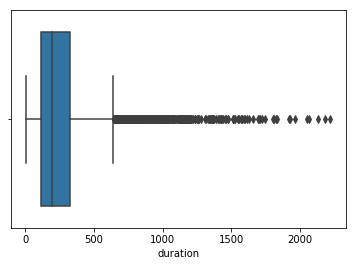

In [256]:
#Duration is continuous and to help organized the data we can have it become 
#categorical by taking a look at the ranges
#The boxplot will help divide the duration into subgroups
sns.boxplot(x ="duration", data = df2);

In [257]:
df2["duration"].describe()

count    8149.000000
mean      261.015094
std       234.633346
min         5.000000
25%       113.000000
50%       194.000000
75%       325.000000
max      2219.000000
Name: duration, dtype: float64

In [258]:
#Looking at the boxplot and summary stats above we can divide age into 5 categories
#and the values can be seen below
df2.loc[df2.duration<113,"duration"] = 1
df2.loc[(df2.duration>=113) & (df.duration<194),"duration"] = 2
df2.loc[(df2.duration>=194) & (df.duration<325),"duration"] = 3
df2.loc[(df2.duration>=325) & (df.duration<650),"duration"] = 4
df2.loc[(df2.duration>=650),"duration"] = 5

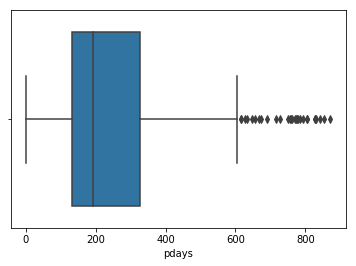

In [259]:
#pdays is continuous and to help organized the data we can have it become categorical
#by taking a look at the ranges
#The boxplot will help divide the pdays into subgroups
sns.boxplot(x ="pdays", data = df2);

In [260]:
df2["pdays"].describe()

count    8149.000000
mean      222.944410
std       111.688832
min         1.000000
25%       133.000000
50%       194.000000
75%       326.000000
max       871.000000
Name: pdays, dtype: float64

In [261]:
#Looking at the boxplot and summary stats above we can divide age into 5 categories
#and the values can be seen below
df2.loc[df2.pdays<133,"pdays"] = 1
df2.loc[(df2.pdays>=133) & (df.pdays<194),"pdays"] = 2
df2.loc[(df2.pdays>=194) & (df.pdays<326),"pdays"] = 3
df2.loc[(df2.pdays>=326) & (df.pdays<600),"pdays"] = 4
df2.loc[(df2.pdays>=600),"pdays"] = 5

In [262]:
#Transform the output variable into numbers
df2["y"]= LabelEncoder().fit_transform(df2['y'])

In [263]:
df2.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,week
24060,2,0,1,2,0,4,0,0,1,21,10,1,1,2,3,0,0,3.0
24062,2,0,2,1,0,2,1,1,1,21,10,4,1,2,1,1,1,3.0
24064,2,7,1,1,0,6,1,0,1,21,10,2,1,1,4,0,1,3.0
24072,2,4,1,2,0,6,1,0,1,22,10,1,1,1,4,1,0,4.0
24077,2,4,1,2,0,2,1,0,1,23,10,2,1,2,3,0,1,4.0


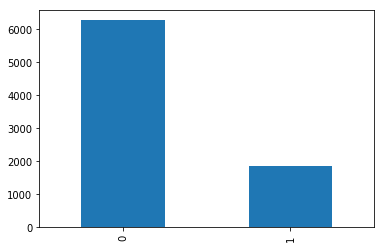

In [264]:
#Taking a look at the Counts we can see that we have an imbalanced dataset
#with the outcomes
pd.value_counts(df2['y']).plot.bar();

# Results and Conclusion

- We are going to see what the results are like when running the Random Forest Classifier on both an imbalanced and balanced dataset.

In [265]:
# Puts together all the feature variables
features = list(df2.columns)

In [266]:
features.remove("y")
features.remove("day")

In [267]:
#List of Features we are going to be looking at
features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing',
 'loan',
 'contact',
 'month',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'week']

In [268]:
X = df2[features].values # Feature variables
Y = df2.y # Outcome Variable

In [269]:
# Splitting our Data using train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size = 0.20)

In [270]:
# Assigning Random Forest to the Classifier
clf = RandomForestClassifier(n_estimators = 200, criterion = 'entropy', random_state = 12, 
                             max_depth=3)

In [271]:
#Doing a 10 folds cross Validation Report
N_folds_cross_validation= 10

def print_cross_validation_report(classifier, data, classes, 
                                  N_folds_cross_validation):
    '''
    Inputs: Classfier, data, Number for N-Folds
    
    Output: Accuracy, F1, Precision, Recall
    '''
    #First print out the accuracy score...
    accuracy = cross_val_score(classifier,
                               data,
                               classes,
                               scoring='accuracy',
                               cv=N_folds_cross_validation)
    print("         Accuracy: %0.2f%% (+/- %0.2f%%)" % (round(100*accuracy.mean(),2), \
                          round(100*accuracy.std(), 2) * 2))

    #Next, print out the F1-Score...
    f1 = cross_val_score(classifier,
                         data,
                         classes,
                         scoring='f1_weighted',
                         cv=N_folds_cross_validation)
    print("         F1-Score: %0.2f%% (+/- %0.2f%%)" % (round(100*f1.mean(),2), \
                          round(100*f1.std(), 2) * 2))
    
    #Then the precision...
    precision = cross_val_score(classifier,
                                data,
                                classes,
                                scoring='precision_weighted',
                                cv=N_folds_cross_validation)
    print("        Precision: %0.2f%% (+/- %0.2f%%)" % (round(100*precision.mean(),2), \
                          round(100*precision.std(), 2) * 2))

    #And finally, the recall...
    recall = cross_val_score(classifier,
                             data,
                             classes,
                             scoring='recall_weighted',
                             cv=N_folds_cross_validation)
    print("           Recall: %0.2f%% (+/- %0.2f%%)" % (round(100*recall.mean(),2), \
                          round(100*recall.std(), 2) * 2))
    

In [272]:
#Fit the model onto the training set
clf.fit(X_train, y_train);

In [273]:
#Run The 10-Fold 
print("\n\n======== CLASSIFIER ACCURACY REPORT ========")
print("      (%d-Fold Cross-Validation Study)\n"%(N_folds_cross_validation))
print_cross_validation_report(clf,
                              X_train,
                              y_train,
                              N_folds_cross_validation)

#Look at the accuracy of the data on the test set
mean_accuracy = clf.score(X_test, y_test)


print("\n\n MEAN ACCURACY ON TEST DATA: %5.2f%%" %(round(100.0*mean_accuracy, 2)))



======== CLASSIFIER ACCURACY REPORT ========
      (10-Fold Cross-Validation Study)

         Accuracy: 82.50% (+/- 2.94%)
         F1-Score: 79.58% (+/- 3.60%)
        Precision: 82.13% (+/- 4.42%)
           Recall: 82.50% (+/- 2.94%)


 MEAN ACCURACY ON TEST DATA: 83.93%


In [274]:
#Get Prediction results
y_pred= clf.predict(X_test)

In [275]:
# The Confusion Matrix, Lookst True Positive, True Negative, 
#False Positive, False Negative 
confusion_matrix(y_test,y_pred)

array([[1253,   19],
       [ 243,  115]])

## Results on Imbalanced Dataset

When looking at the results of the imbalanced dataset you can see all the scores are high and this is because the data is more likely to guess that the client will not suscribe to the term deposit.

This is shown by the confusion matrix above. The True Positive rate is 1253 while the True Negative is 115. 

In [302]:
df2.y.value_counts()

0    6274
1    1875
Name: y, dtype: int64

## Creating Balanced Dataset

To Create a balanced data set I will be doing Up-Sampling. This will randomly duplicate data from the minority class which in this scenario is suscribing to a term deposit. 

To learn more about this I used this website as a reference: <https://elitedatascience.com/imbalanced-classes>

In [288]:
# Assigning majority and minority 
df2_majority = df2[df2.y==0]
df2_minority = df2[df2.y==1]

In [289]:
# Resample function will create more values of the minority
df2_minority_upsampled = resample(df2_minority, 
                                 replace=True,  
                                 n_samples=6274,    
                                 random_state=123) 

In [290]:
# We now will combine the datasets so we have an equal number of classes
df2_upsampled = pd.concat([df2_majority, df2_minority_upsampled])

In [291]:
# This is to confirm the equal number of outcomes
df2_upsampled.y.value_counts()

1    6274
0    6274
Name: y, dtype: int64

In [292]:
X2 = df2_upsampled[features].values # Feature variables
Y2 = df2_upsampled.y

In [293]:
# Splitting our Data using train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X2, Y2,test_size = 0.20)

In [294]:
clf.fit(X_train, y_train);

In [295]:
print("\n\n======== CLASSIFIER ACCURACY REPORT ========")
print("      (%d-Fold Cross-Validation Study)\n"%(N_folds_cross_validation))
print_cross_validation_report(clf,
                              X_train,
                              y_train,
                              N_folds_cross_validation)

mean_accuracy = clf.score(X_test, y_test)

print("\n\n MEAN ACCURACY ON TEST DATA: %5.2f%%" %(round(100.0*mean_accuracy, 2)))



======== CLASSIFIER ACCURACY REPORT ========
      (10-Fold Cross-Validation Study)

         Accuracy: 78.31% (+/- 2.44%)
         F1-Score: 78.28% (+/- 2.44%)
        Precision: 78.48% (+/- 2.52%)
           Recall: 78.31% (+/- 2.44%)


 MEAN ACCURACY ON TEST DATA: 77.65%


In [296]:
y_pred= clf.predict(X_test)

In [297]:
confusion_matrix(y_test,y_pred)

array([[985, 266],
       [295, 964]])

## Results of Balanced Dataset

You can now see the accuracy has fallen to 77%. With the confusion matrix having equal samples in each category as well. Overall we were able to build a predictive model with a good accuracy rate. We can now confirm that we can determine whether or not a client is likely to suscribe to a term deposit.

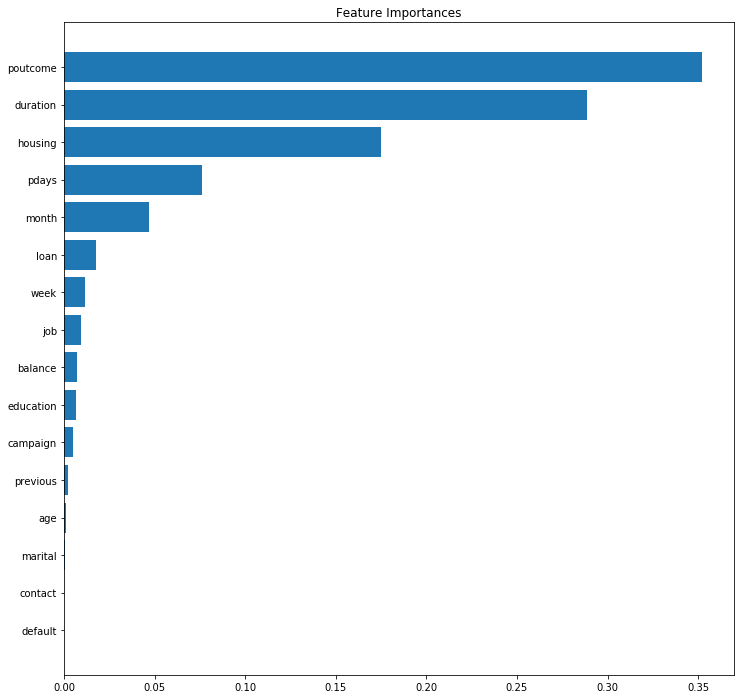

In [299]:
# Code to see which features are important. 
#Appending the values and then plotting it to get a visual
xvals = range(len(features))
important = clf.feature_importances_ # list of feature importances
indices = np.argsort(important)
features_sorted = []

for i in range(len(indices)):
    features_sorted.append(features[indices[i]])
fig = plt.figure(figsize=[12,12])
plt.title("Feature Importances")
plt.barh(xvals, important[indices], tick_label=features_sorted)
plt.show() 

# Discussion

As you can see above when doing the random forest classifier the 3 most important features were poutcome, housing, and duration.

It makes sense that the past outcome plays the biggest role in determining whether or not a client would suscribe to a term deposit. As shown with the graph below the people that said no previously are more likely to say no again while the people that said yes before are more likely to say yes again.

Duration also makes sense in that if the phone call lasted longer they are more likely to suscribe to a term deposit because they are interested with the marketing of it. 

Housing was interesting in that people with a housing loan are not likely to suscribe to a term deposit. This makes sense with the fact that people with housing loans don't have extra money for an investment

Overall looking at the results a predictive model can be made to see a client will suscrible to a term deposit

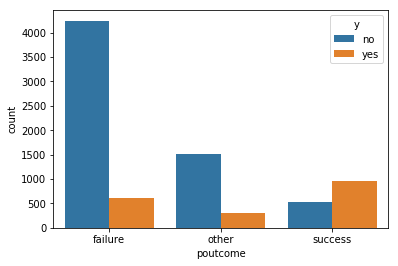

In [327]:
sns.countplot(x ="poutcome", hue ="y", data=df);

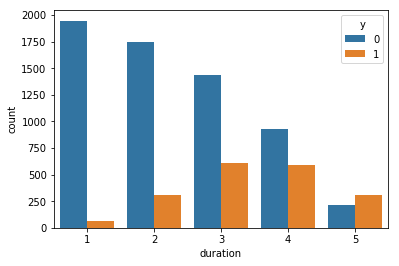

In [317]:
sns.countplot(x ="duration", hue ="y", data=df2);

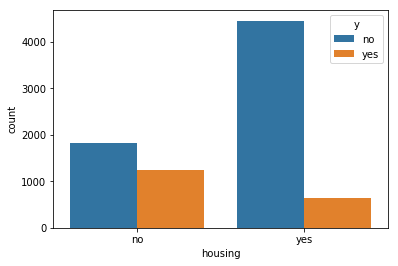

In [318]:
sns.countplot(x ="housing", hue ="y", data=df);

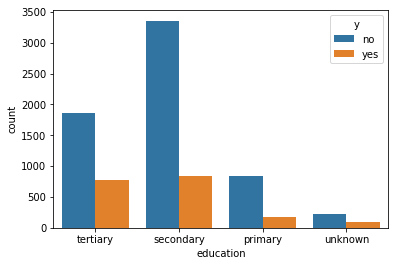

In [314]:
sns.countplot(x ="education", hue ="y", data=df);

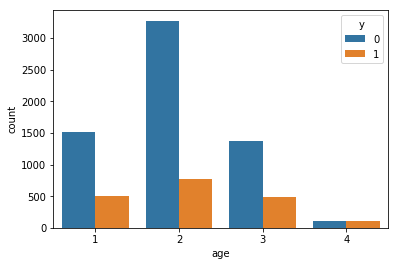

In [321]:
sns.countplot(x ="age", hue ="y", data=df2);